In [202]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
from scipy.stats import norm
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula # Using Copulae Module
import seaborn as sns
from scipy.stats import kendalltau

In [235]:
# Set dataset dir

dataset = '../../datasets/'
et = os.path.join(dataset, 'et/gha_lsa_et.nc')
precipitation = os.path.join(dataset, 'precipitation_chirps/precip_chirps_gha.nc')
tws = os.path.join(dataset, 'gha_tws.nc')
water_mask = os.path.join(dataset, 'water_mask/water_body.shp')
landform = os.path.join(dataset, 'landform/landform.tif')

In [ ]:
# Open the raster file
with rasterio.open(landform) as src:
    # Read the data (assuming it's a single band)
    data = src.read(1)  # Read the first band
    
    # Get the unique categories in the data
    categories = np.unique(data)
    print(f"Categories found: {categories}")

    # Mask any nodata values (if specified in the file)
    nodata = src.nodata
    if nodata is not None:
        data = np.ma.masked_where(data == nodata, data)

# Plot the data with a categorical colormap
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis')  # 'tab20' is good for up to 20 distinct categories
plt.colorbar(label='Landform Category')
plt.title('Landform Categories')
plt.show()

In [236]:
# Open and display

et_data = xr.open_dataset(et)['ET']

precipitation_data = xr.open_dataset(precipitation)['precipitation']

tws_data = xr.open_dataset(tws)['twsddk']

# Load the landform GeoTIFF
landform_data = rxr.open_rasterio(landform)

In [237]:
tws_data = tws_data.sel(time=slice('2004-01-01', None))

# Convert units: tws (m) to mm
tws_data = tws_data * 1000 

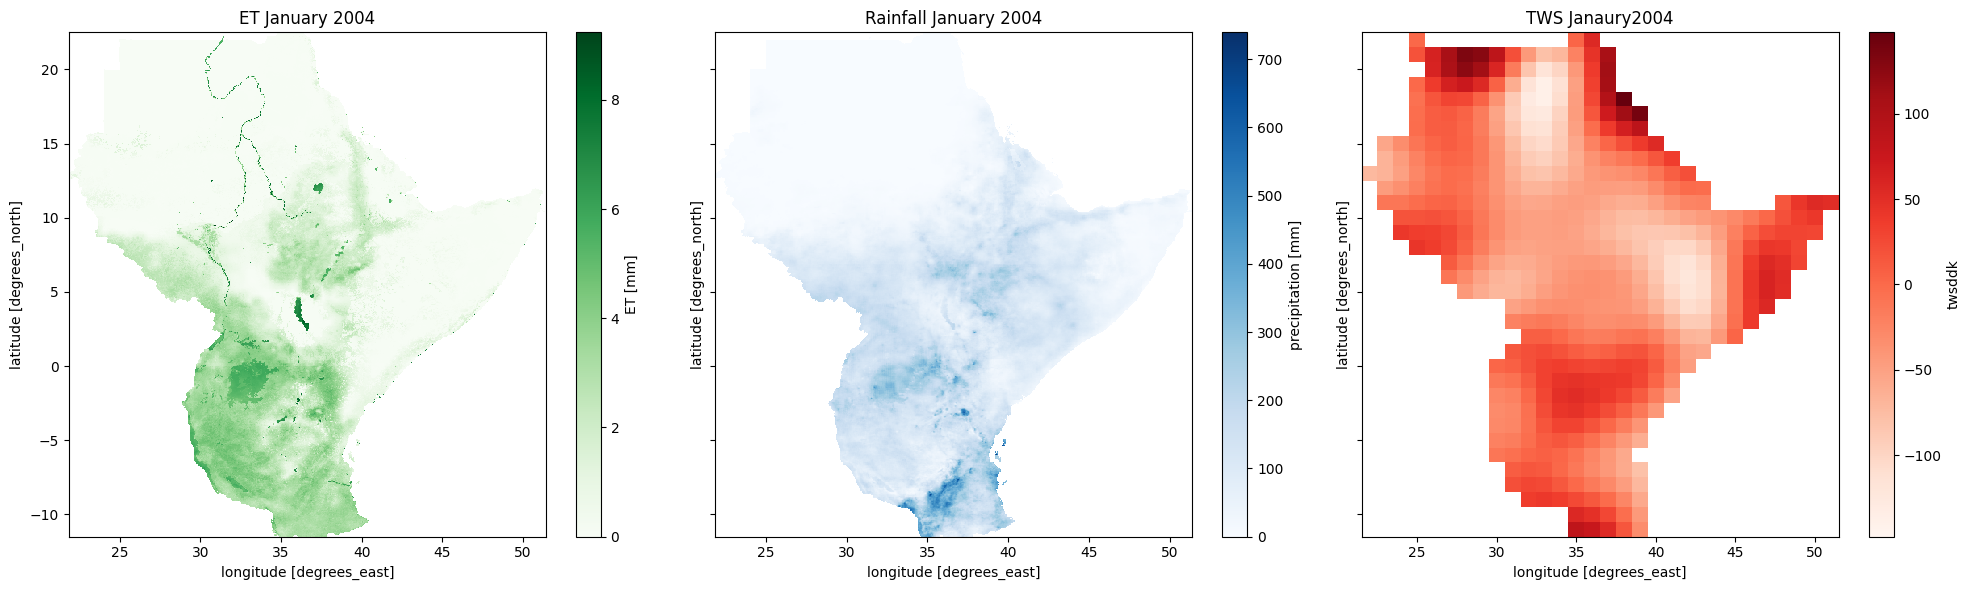

In [206]:
et1 = et_data.isel(time=0)
precip1 = precipitation_data.isel(time=0)
tws1 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et1.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET January {}".format(et1.time.dt.year.values))

# Plot Rainfall
precip1.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall January {}".format(precip1.time.dt.year.values))

# Plot TWS
tws1.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS Janaury{}".format(tws1.time.dt.year.values))

plt.tight_layout()
plt.show()

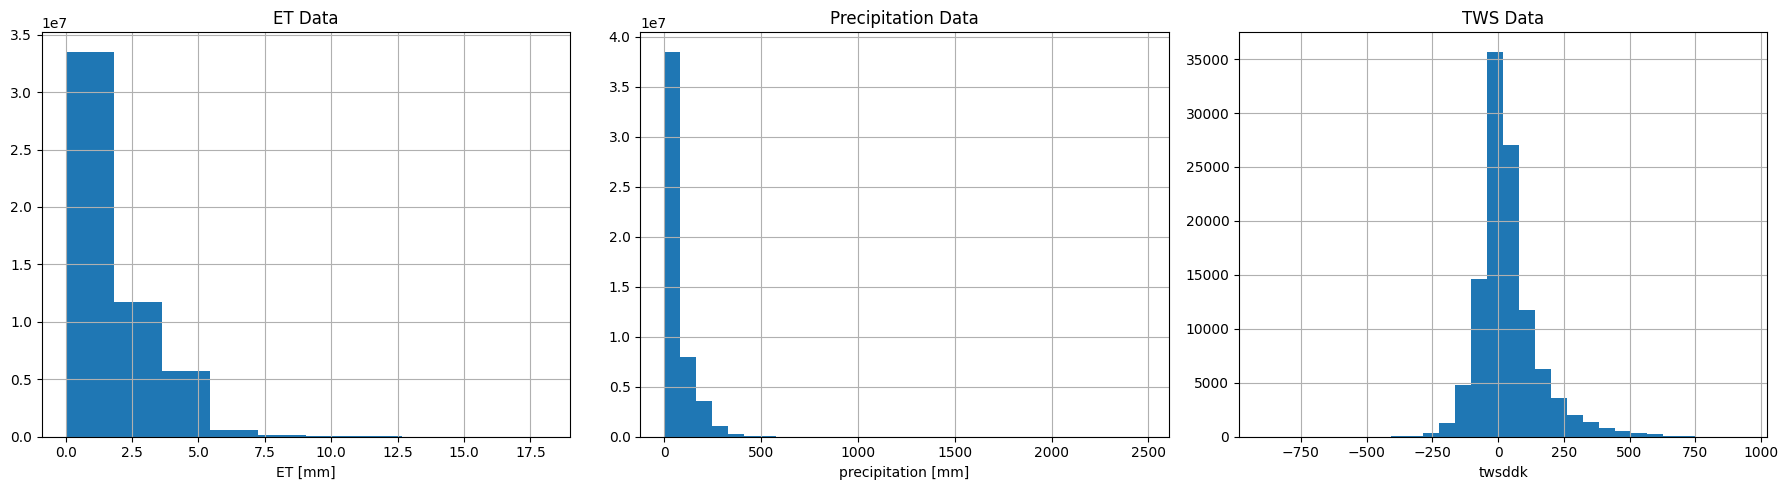

In [207]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et_data.plot.hist(ax=axes[0], bins=10)
axes[0].grid(True)
axes[0].set_title('ET Data')

precipitation_data.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws_data.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

In [ ]:
# Variables at a location in GHA

lat = 5.34
lon = 45.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (mm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

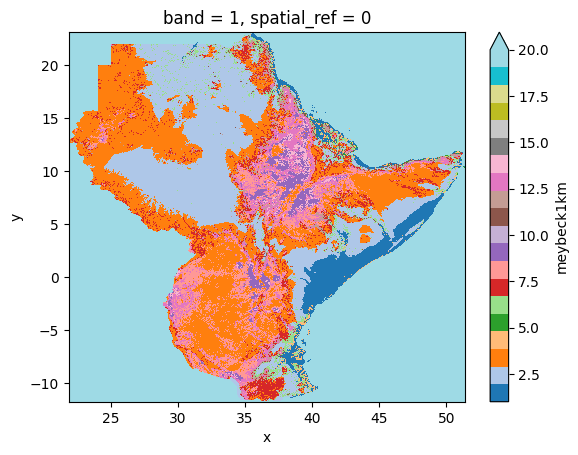

In [208]:
landform_data.plot(cmap='tab20', vmax=20)

#### Large TS Plots

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(et_poi.time, et_poi.values, color='green', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Evapotranspiration (mm)")
# plt.title("Time Series Plot")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("TWS (mm)")
# plt.title("Time Series Plot")
plt.show()


#### Spatial Alignment

In [247]:
tws_data.rio.write_crs("EPSG:4326", inplace=True)
et_data.rio.write_crs("EPSG:4326", inplace=True)
precipitation_data.rio.write_crs("EPSG:4326", inplace=True)

# Spatial upscale to 1-degree
et_resampled = et_data.rio.reproject_match(
    tws_data, resampling=rasterio.enums.Resampling.average
).rename({"x": "lon", "y": "lat"})
precip_resampled = precipitation_data.rio.reproject_match(
    tws_data, resampling=rasterio.enums.Resampling.average
).rename({"x": "lon", "y": "lat"})


In [255]:
tws_data = tws_data.transpose('time', 'lat', 'lon')

In [256]:
tws_data

<xarray.DataArray 'twsddk' (time: 219, lat: 34, lon: 30)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
  * lat          (lat) float64 -11.0 -10.0 -9.0 -8.0 ... 19.0 20.0 21.0 22.0
  * lon          (lon) float64 22.0 23.0 24.0 25.0 26.0 ... 48.0 49.0 50.0 51.0
    spatial_ref  int64 0

In [263]:
tws_data.rio.write_crs("EPSG:4326", inplace=True)
et_data.rio.write_crs("EPSG:4326", inplace=True)
precipitation_data.rio.write_crs("EPSG:4326", inplace=True)

# Spatial upscale to 1-degree
tws_resampled = tws_data.rio.reproject_match(
    precipitation_data,
    resampling=rasterio.enums.Resampling.nearest  # Smooth interpolation
)
et_resampled = et_data.rio.reproject_match(
    precipitation_data,
    resampling=rasterio.enums.Resampling.nearest
)

In [260]:
# Temporal alignment (already done, but ensure consistency)
tws_resampled = tws_resampled.interp(time=precipitation_data.time, method="linear")
et_resampled = et_resampled.interp(time=precipitation_data.time, method="linear")

# Verify new shapes
print("New shapes:", tws_resampled.shape, et_resampled.shape, precip_data.shape)

New shapes: (250, 698, 591) (250, 698, 591) (219, 12)


ValueError: Axis limits cannot be NaN or Inf

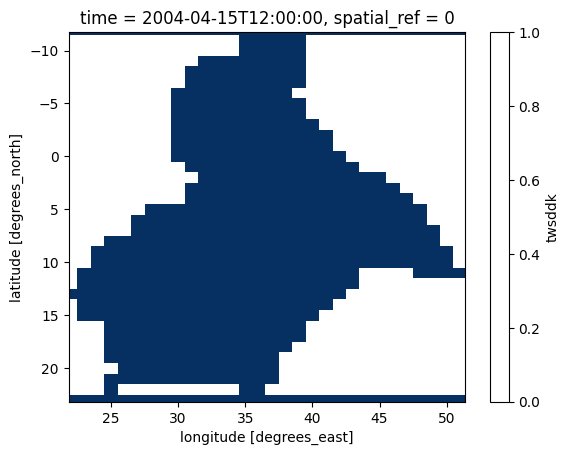

In [265]:
tws_resampled.isel(time=3).plot()

In [270]:
# Extract coordinates from the precipitation grid
target_lat = precipitation_data["y"]  # Latitude coordinates of precipitation grid
target_lon = precipitation_data["x"]  # Longitude coordinates of precipitation grid

# Interpolate TWS to the precipitation grid
tws_interpolated = tws_data.interp(
    lat=target_lat,
    lon=target_lon,
    method="nearest"  # You can use "linear", "nearest", or "cubic"
)

# # Save or use the interpolated TWS data
# tws_interpolated.to_netcdf("tws_interpolated.nc")  # Save to a new file

In [272]:
tws_interpolated.isel(time=4).shape

(698, 591)

ValueError: Axis limits cannot be NaN or Inf

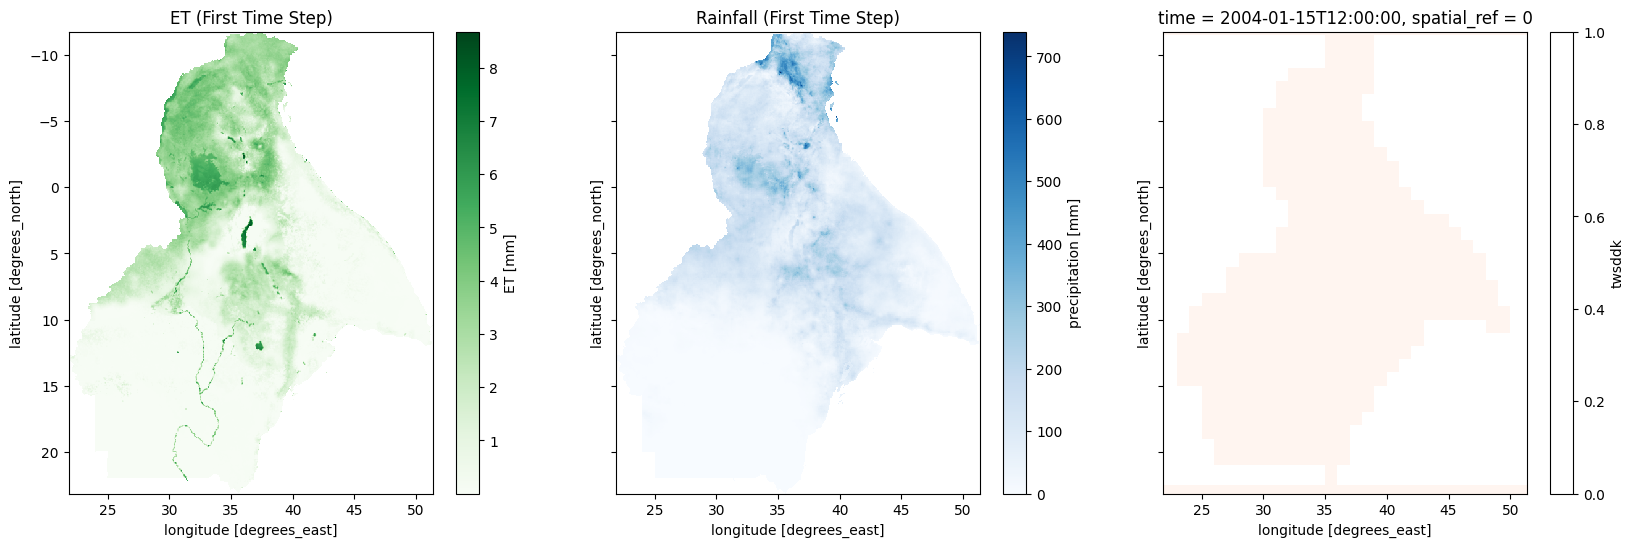

In [258]:
# Plot the regrided datasets

et2 = et_resampled.isel(time=0)
precip2 = precipitation_data.isel(time=0)
tws2 = tws_resampled.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et2.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip2.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws2.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

plt.tight_layout()
plt.show()

In [273]:
# Assign CRS if not already present
landform_data.rio.write_crs("EPSG:4326", inplace=True)

# Reproject landform data to match the 1-degree TWS grid
landform_resampled = landform_data.rio.reproject_match(
    precipitation_data, resampling=rasterio.enums.Resampling.nearest
).rename({"x": "lon", "y": "lat"})

In [274]:
np.unique(landform_data.values)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15, 255], dtype=uint8)

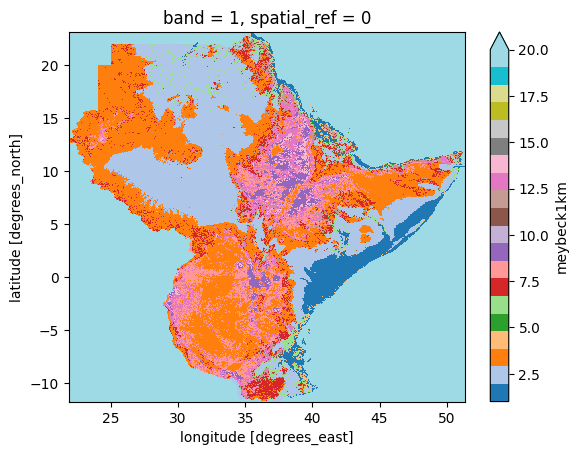

In [275]:
landform_resampled.plot(cmap='tab20', vmax=20)

In [276]:
landform_resampled.rio.to_raster("output.tif")

In [214]:
landform_2d = landform_resampled.isel(band=0).squeeze()

In [215]:
# Get unique landform classes (subregions)
landform_classes = np.unique(landform_2d.values)
print("Landform classes:", landform_classes)

Landform classes: [  1   2   3   5   6   7   8   9  11  12  13  14 255]


#### Temporal alignment

In [ ]:
common_time = tws_data.time
et_resampled = et_resampled.sel(time=common_time, method="nearest")
precip_resampled = precip_resampled.sel(time=common_time, method="nearest")

In [216]:
# Temporal interpolation to match tws.time
et_resampled = et_resampled.interp(time=common_time, method="linear")
precip_resampled = precip_resampled.interp(time=common_time, method="linear")

In [ ]:
et_resampled_

In [ ]:
precip_resampled_.time.values[:10]

#### Exponential moving average

In [ ]:
# Span = timestep
def apply_ema(da, span=3):
    return da.rolling_exp(time=span, window_type="span").mean()


ds_et_ema = apply_ema(et_resampled, span=6)
ds_precip_ema = apply_ema(precip_resampled, span=6)

In [ ]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = ds_et_ema.sel(y=lat, x=lon, method='nearest')
pre_poi = ds_precip_ema.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [277]:
# Dictionary to store data per subregion
subregion_data = {}

for class_value in landform_classes:
    if np.isnan(class_value): 
        continue
    # Create a mask for the current landform class
    mask = landform_2d == class_value

    # Apply mask to each dataset
    tws_subregion = tws_data.where(mask, drop=True)
    et_subregion = et_resampled.where(mask, drop=True)
    precip_subregion = precip_resampled.where(mask, drop=True)

    # Store in dictionary (you can flatten spatial dims if needed)
    subregion_data[class_value] = {
        "tws": tws_subregion,
        "et": et_subregion,
        "precip": precip_subregion
    }

ValueError: Dimensions {'lat', 'lon'} do not exist. Expected one or more of Frozen({'x': 591, 'y': 698, 'time': 252})

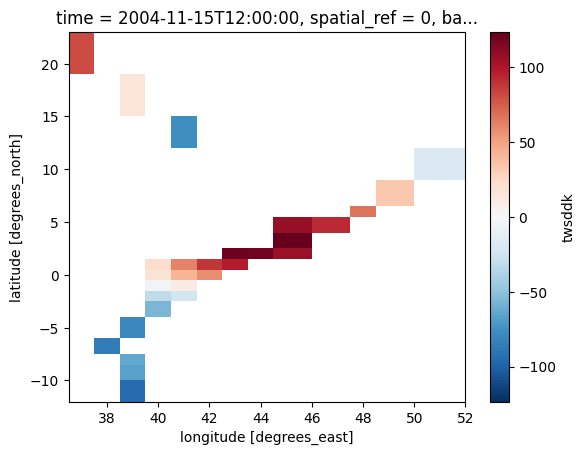

In [218]:
subregion_data[1]['tws'].isel(time=10).plot()

### Anomalies Calculation

#### Evapotranspitation

In [ ]:
# Calculate monthly climatology (mean for each month over the years)
et_climatology = et_data.groupby("time.month").mean("time")

# Calculate anomalies
et_anomalies = et_data.groupby("time.month") - et_climatology

# Calculate monthly standard deviation over the years
et_std = et_data.groupby("time.month").std("time")

# Calculate standardized anomalies
et_standardized_anomalies = et_anomalies / et_std


In [ ]:
et_standardized_anomalies

#### Precipitation

In [ ]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_data.groupby("time.month").mean("time")

# Calculate anomalies
precipitation_anomalies = precipitation_data.groupby("time.month") - precipitation_clim

# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_data.groupby("time.month").std("time")

# Calculate standardized anomalies
pre_standardized_anomalies = precipitation_anomalies / precipitation_std


In [ ]:
pre_standardized_anomalies

#### TWS

In [ ]:
# Calculate monthly climatology (mean for each month over the years)
tws_clim = tws_data.groupby("time.month").mean("time")

# Calculate anomalies
tws_anomalies = tws_data.groupby("time.month") - tws_clim

# Calculate the standard deviation for each month over the years
tws_std = tws_data.groupby("time.month").std("time")

# Calculate standardized anomalies
tws_standardized_anomalies = tws_anomalies / tws_std


In [ ]:
tws_standardized_anomalies

### Standardization with regridded data

In [ ]:
# ET
et_climatology = et_resampled.groupby("time.month").mean("time")
et_anomalies = et_resampled.groupby("time.month") - et_climatology
et_std = et_resampled.groupby("time.month").std("time")
et_st_anomalies = et_anomalies.groupby("time.month") / et_std

In [ ]:
# Preciptation
precipitation_clim = precip_resampled.groupby("time.month").mean("time")
precipitation_anomalies = precip_resampled.groupby("time.month") - precipitation_clim
precipitation_std = precip_resampled.groupby("time.month").std("time")
pre_st_anomalies = precipitation_anomalies.groupby("time.month") / precipitation_std


In [ ]:
# TWS
tws_clim = tws_data.groupby("time.month").mean("time")
tws_anomalies = tws_data.groupby("time.month") - tws_clim
tws_std = tws_data.groupby("time.month").std("time")
tws_st_anomalies = tws_anomalies.groupby("time.month") / tws_std

In [ ]:
# ET
et_climatology = ds_et_aligned.groupby("time.month").mean("time")
et_anomalies = ds_et_aligned.groupby("time.month") - et_climatology
et_std = ds_et_aligned.groupby("time.month").std("time")
et_st_anomalies = et_anomalies.groupby("time.month") / et_std

# Preciptation
precipitation_clim = ds_precip_aligned.groupby("time.month").mean("time")
precipitation_anomalies = ds_precip_aligned.groupby("time.month") - precipitation_clim
precipitation_std = ds_precip_aligned.groupby("time.month").std("time")
pre_st_anomalies = precipitation_anomalies.groupby("time.month") / precipitation_std

# TWS
tws_clim = tws_data.groupby("time.month").mean("time")
tws_anomalies = tws_data.groupby("time.month") - tws_clim
tws_std = tws_data.groupby("time.month").std("time")
tws_st_anomalies = tws_anomalies.groupby("time.month") / tws_std

#### Export the anomalies

In [ ]:
# et_st_anomalies.to_netcdf(os.path.join(dataset, 'et_standardized_anomaly.nc'))
# pre_st_anomalies.to_netcdf(os.path.join(dataset, 'precip_standardized_anomaly.nc'))
# tws_st_anomalies.to_netcdf(os.path.join(dataset, 'tws_standardized_anomaly.nc'))

### Regional Anomalies

In [219]:
# Loop through each subregion
for class_value in subregion_data:
    # Extract raw data for the subregion
    tws = subregion_data[class_value]["tws"]
    et = subregion_data[class_value]["et"]
    precip = subregion_data[class_value]["precip"]

    tws_mean = tws.groupby("time.month").mean("time", skipna=True)
    tws_std = tws.groupby("time.month").std("time", skipna=True)
    
    et_mean = et.groupby("time.month").mean("time", )
    et_std = et.groupby("time.month").std("time", )
    
    precip_mean = precip.groupby("time.month").mean("time", skipna=True)
    precip_std = precip.groupby("time.month").std("time", skipna=True)
    
    # Calculate monthly anomalies
    tws_anomaly = tws.groupby("time.month") - tws_mean
    et_anomaly = et.groupby("time.month") - et_mean
    precip_anomaly = precip.groupby("time.month") - precip_mean

    # Calculate standardized anomalies
    tws_st_anomaly = tws_anomaly / tws_std
    et_st_anomaly = et_anomaly / et_std
    precip_st_anomaly = precip_anomaly / precip_std

    # Store the anomalies
    subregion_data[class_value]["tws_anomaly"] = tws_st_anomaly
    subregion_data[class_value]["et_anomaly"] = et_st_anomaly
    subregion_data[class_value]["precip_anomaly"] = precip_st_anomaly

In [ ]:
et

In [ ]:
# Loop through each subregion
for class_value in subregion_data:
    # Extract raw data for the subregion
    tws = subregion_data[class_value]["tws"]
    et = subregion_data[class_value]["et"]
    precip = subregion_data[class_value]["precip"]

    tws_mean = tws.mean(dim="time")
    tws_std = tws.std(dim="time")
    et_mean = et.mean(dim="time")
    et_std = et.std(dim="time")
    precip_mean = precip.mean(dim="time")
    precip_std = precip.std(dim="time")

    # Calculate standardized anomalies
    tws_anomaly = (tws - tws_mean) / tws_std
    et_anomaly = (et - et_mean) / et_std
    precip_anomaly = (precip - precip_mean) / precip_std

    # Store the anomalies
    subregion_data[class_value]["tws_anomaly"] = tws_anomaly
    subregion_data[class_value]["et_anomaly"] = et_anomaly
    subregion_data[class_value]["precip_anomaly"] = precip_anomaly

In [ ]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
# valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[~np.isnan(tws_anomaly_1)]
et_anomaly_1 = et_anomaly_1[~np.isnan(et_anomaly_1)]
precip_anomaly_1 = precip_anomaly_1[~np.isnan(precip_anomaly_1)]

In [ ]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

In [220]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

In [221]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

(8628,) (8628,) (8628,)


In [ ]:
# Assuming landform_classes = [1, 2, 3] (adjust based on your data)
# Process each subregion separately

# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

# Transform to uniform [0,1] for class 1
u_tws_1 = stats.norm.cdf(tws_anomaly_1)
u_et_1 = stats.norm.cdf(et_anomaly_1)
u_precip_1 = stats.norm.cdf(precip_anomaly_1)

# Store transformed data for class 1
subregion_data[1]["u_tws"] = u_tws_1
subregion_data[1]["u_et"] = u_et_1
subregion_data[1]["u_precip"] = u_precip_1

# Subregion 2 (class_value = 2)
tws_anomaly_2 = subregion_data[2]["tws_anomaly"].values.flatten()
et_anomaly_2 = subregion_data[2]["et_anomaly"].values.flatten()
precip_anomaly_2 = subregion_data[2]["precip_anomaly"].values.flatten()

# Remove NaNs for class 2
valid_2 = ~np.isnan(tws_anomaly_2) & ~np.isnan(et_anomaly_2) & ~np.isnan(precip_anomaly_2)
tws_anomaly_2 = tws_anomaly_2[valid_2]
et_anomaly_2 = et_anomaly_2[valid_2]
precip_anomaly_2 = precip_anomaly_2[valid_2]

# Transform to uniform [0,1] for class 2
u_tws_2 = stats.norm.cdf(tws_anomaly_2)
u_et_2 = stats.norm.cdf(et_anomaly_2)
u_precip_2 = stats.norm.cdf(precip_anomaly_2)

# Store transformed data for class 2
subregion_data[2]["u_tws"] = u_tws_2
subregion_data[2]["u_et"] = u_et_2
subregion_data[2]["u_precip"] = u_precip_2

# Subregion 3 (class_value = 3)
tws_anomaly_3 = subregion_data[3]["tws_anomaly"].values.flatten()
et_anomaly_3 = subregion_data[3]["et_anomaly"].values.flatten()
precip_anomaly_3 = subregion_data[3]["precip_anomaly"].values.flatten()

# Remove NaNs for class 3
valid_3 = ~np.isnan(tws_anomaly_3) & ~np.isnan(et_anomaly_3) & ~np.isnan(precip_anomaly_3)
tws_anomaly_3 = tws_anomaly_3[valid_3]
et_anomaly_3 = et_anomaly_3[valid_3]
precip_anomaly_3 = precip_anomaly_3[valid_3]

# Transform to uniform [0,1] for class 3
u_tws_3 = stats.norm.cdf(tws_anomaly_3)
u_et_3 = stats.norm.cdf(et_anomaly_3)
u_precip_3 = stats.norm.cdf(precip_anomaly_3)

# Store transformed data for class 3
subregion_data[3]["u_tws"] = u_tws_3
subregion_data[3]["u_et"] = u_et_3
subregion_data[3]["u_precip"] = u_precip_3

# Optional: Print to compare at a glance
print("Subregion 1 - Mean u_tws:", u_tws_1.mean(), "u_et:", u_et_1.mean(), "u_precip:", u_precip_1.mean())
print("Subregion 2 - Mean u_tws:", u_tws_2.mean(), "u_et:", u_et_2.mean(), "u_precip:", u_precip_2.mean())
print("Subregion 3 - Mean u_tws:", u_tws_3.mean(), "u_et:", u_et_3.mean(), "u_precip:", u_precip_3.mean())

## Marginal Distribution

#### Clean data and stack

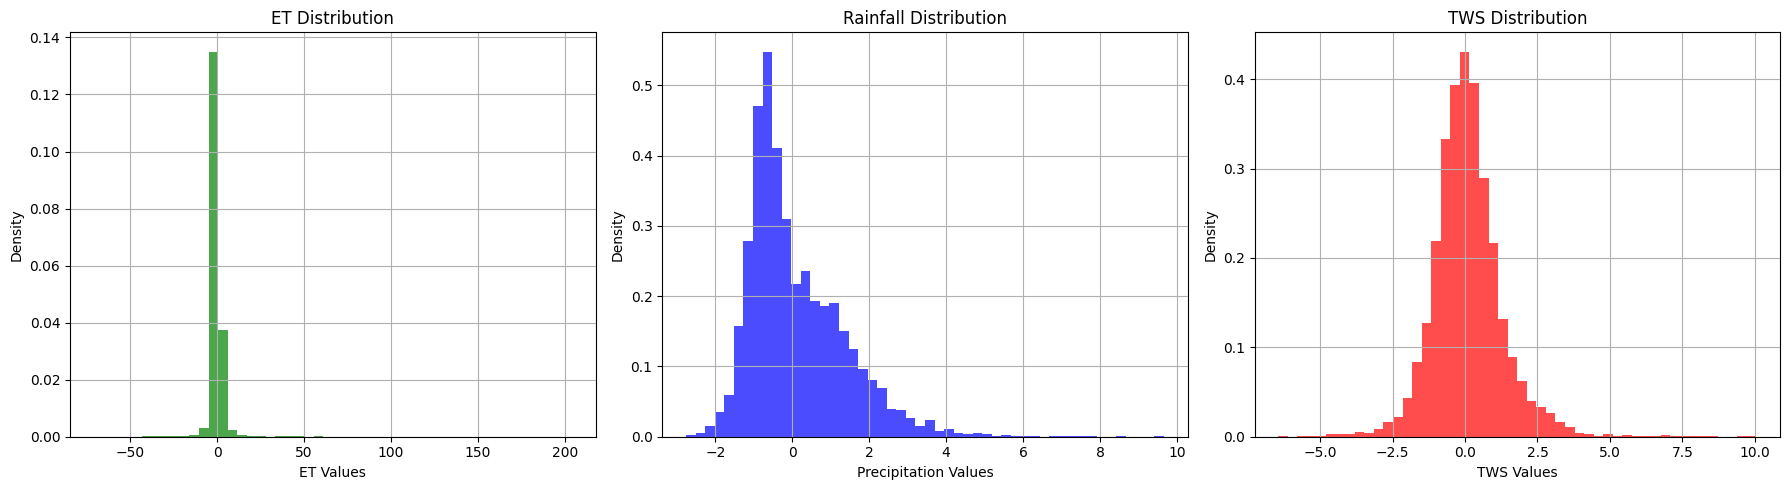

In [222]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [223]:
# Compute ECDF for ET
ecdf_et = ECDF(et_anomaly_1)

# Compute ECDF for Precipitation
ecdf_precip = ECDF(precip_anomaly_1)

# Compute ECDF for TWS
ecdf_twsa = ECDF(tws_anomaly_1)


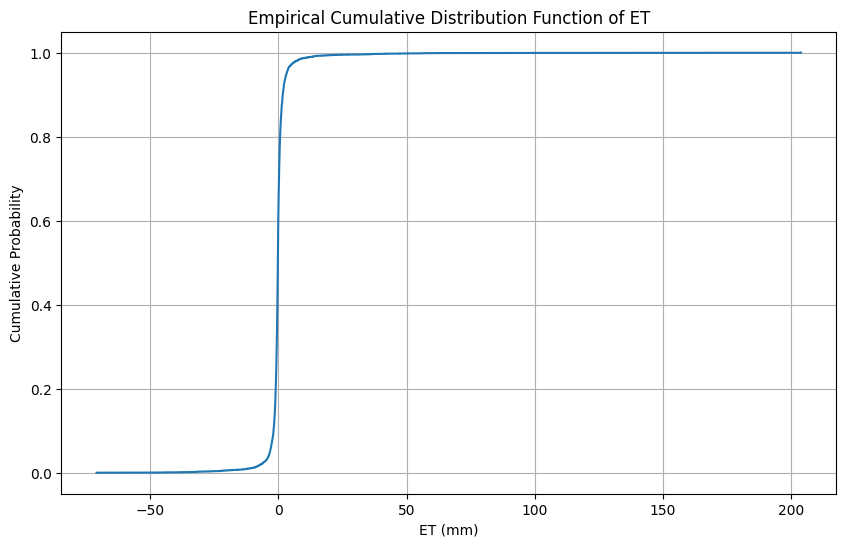

In [224]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

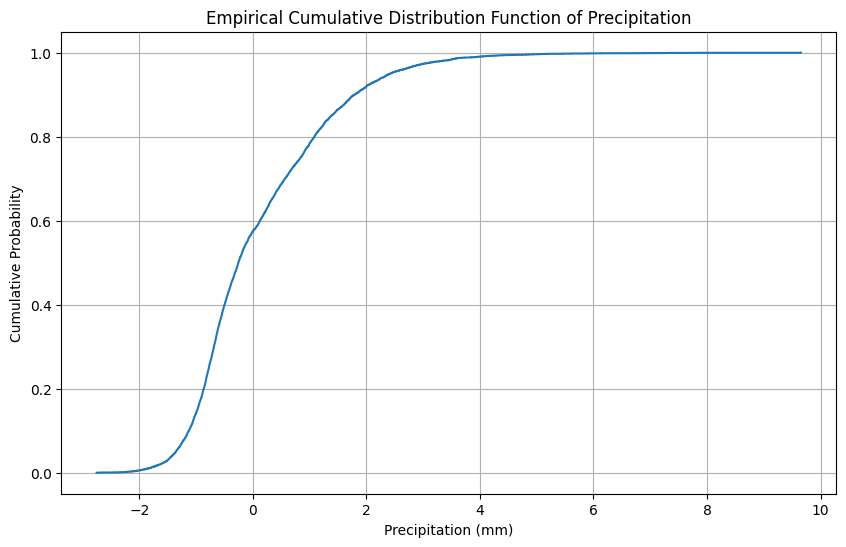

In [225]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_precip.x, ecdf_precip.y, where='post')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of Precipitation')
plt.grid(True)
plt.show()


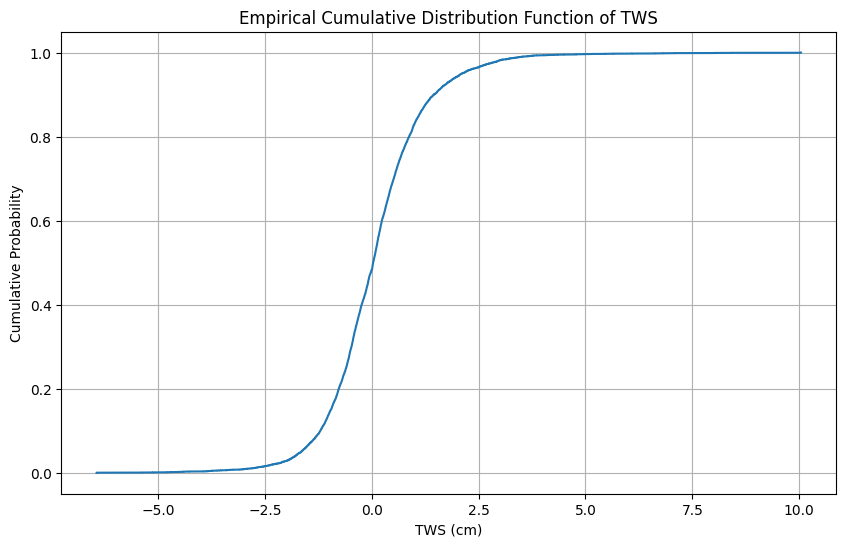

In [226]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_twsa.x, ecdf_twsa.y, where='post')
plt.xlabel('TWS (cm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of TWS')
plt.grid(True)
plt.show()

In [227]:
len(et_anomaly_1)

8628

#### Transform to uniform margin

In [228]:
# Transform TWSA data
uniform_twsa = ecdf_twsa(tws_anomaly_1)

# Transform Precip data
uniform_precip = ecdf_precip(precip_anomaly_1)

# Transform ET data
uniform_et = ecdf_et(et_anomaly_1)


#### Copula Fitting

In [229]:
# Select subset of the data
uniform_data = np.column_stack([uniform_et, uniform_precip, uniform_twsa])

In [230]:
# Initialize copulas
copulas = {
    # Elliptical Copulas
    "Gaussian": GaussianCopula(dim=3), 
    "t-Copula": StudentCopula(dim=3),
    
    # Archimidean Copulas
    "Frank": FrankCopula(dim=3),
    "Clayton": ClaytonCopula(dim=3),
    "Gumbel": GumbelCopula(dim=3)
}


In [231]:

results = {}
for name, copula in copulas.items():
    try:
        copula.fit(uniform_data)
        
        # log-likelihood
        log_lik = copula.log_lik(uniform_data)
        
        if name == 't-Copula':
            n_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            n_params = np.array(copula.params).size
        elif name == 'Gaussian':
            n_params = copula.params.size
        aic = -2 * log_lik + 2 * n_params
        bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
        
        #
        
        results[name] = {"Log-Likelihood": log_lik, "AIC": aic, "BIC": bic, "Parameters": copula.params}
        print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    except Exception as e:
        print(f"Error fitting {name} Copula: {e}")

# Step 4: Select the best copula
best_copula_aic = min(results.items(), key=lambda x: x[1]["AIC"])
best_copula_bic = min(results.items(), key=lambda x: x[1]["BIC"])

print("\nBest Copula by AIC:")
print(f"Name: {best_copula_aic[0]}, AIC: {best_copula_aic[1]['AIC']:.2f}, Parameters: {best_copula_aic[1]['Parameters']}")
print("Best Copula by BIC:")
print(f"Name: {best_copula_bic[0]}, BIC: {best_copula_bic[1]['BIC']:.2f}, Parameters: {best_copula_bic[1]['Parameters']}")

# Optional: Store the best copula for further use
best_copula_name = best_copula_aic[0]  # or use BIC
best_copula = copulas[best_copula_name]

Gaussian Copula: Log-Likelihood=128.36, AIC=-250.72, BIC=-229.53
t-Copula Copula: Log-Likelihood=127.56, AIC=-249.12, BIC=-227.93
Error fitting Frank Copula: theta must be positive when dim > 2
Error fitting Clayton Copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


Gumbel Copula: Log-Likelihood=-0.00, AIC=2.00, BIC=9.06

Best Copula by AIC:
Name: Gaussian, AIC: -250.72, Parameters: [-0.13596645  0.01853576 -0.10545472]
Best Copula by BIC:
Name: Gaussian, BIC: -229.53, Parameters: [-0.13596645  0.01853576 -0.10545472]


In [ ]:
# lower_tail = np.mean((u_data[:, 0] < 0.1) & (u_data[:, 1] < 0.1))
# print(f"Observed Lower Tail Dependence: {lower_tail:.3f}")

In [ ]:
best_copula

### Tail

In [ ]:

et = et_anomaly_1
tws = tws_anomaly_1
precip = precip_anomaly_1
# Put data into a DataFrame for convenience
data = pd.DataFrame({'ET': et, 'TWS': tws, 'Precip': precip})


In [ ]:

# 1. Pairwise Scatterplots
plt.figure(figsize=(12, 4))

# ET vs Precip
plt.subplot(1, 3, 1)
plt.scatter(data['ET'], data['Precip'], alpha=0.5)
plt.xlabel('ET')
plt.ylabel('Precip')
plt.title('ET vs Precip')

# ET vs TWS
plt.subplot(1, 3, 2)
plt.scatter(data['ET'], data['TWS'], alpha=0.5)
plt.xlabel('ET')
plt.ylabel('TWS')
plt.title('ET vs TWS')

# TWS vs Precip
plt.subplot(1, 3, 3)
plt.scatter(data['TWS'], data['Precip'], alpha=0.5)
plt.xlabel('TWS')
plt.ylabel('Precip')
plt.title('TWS vs Precip')

plt.tight_layout()
plt.show()



In [ ]:

# 1. Pairwise Scatterplots
plt.figure(figsize=(12, 4))

# ET vs Precip
plt.subplot(1, 3, 1)
plt.scatter(data['ET'], data['Precip'], alpha=0.5)
plt.xlabel('ET')
plt.ylabel('Precip')
plt.title('ET vs Precip')

# ET vs TWS
plt.subplot(1, 3, 2)
plt.scatter(data['ET'], data['TWS'], alpha=0.5)
plt.xlabel('ET')
plt.ylabel('TWS')
plt.title('ET vs TWS')

# TWS vs Precip
plt.subplot(1, 3, 3)
plt.scatter(data['TWS'], data['Precip'], alpha=0.5)
plt.xlabel('TWS')
plt.ylabel('Precip')
plt.title('TWS vs Precip')

plt.tight_layout()
plt.show()



In [ ]:
# 2. Kendall’s Tau Correlation
pairs = [('ET', 'Precip'), ('ET', 'TWS'), ('TWS', 'Precip')]
print("\nKendall's Tau Correlations:")
for var1, var2 in pairs:
    tau, p_value = kendalltau(data[var1], data[var2])
    print(f"{var1} vs {var2}: Tau = {tau:.3f}, p-value = {p_value:.3f}")
    # Note: p-value < 0.05 suggests significant dependence


In [ ]:
# 3. Tail Dependence Check (Lower and Upper 10%)
def check_tail_dependence(x, y, tail_percent=0.1):
    n = len(x)
    threshold = int(n * tail_percent)
    
    # Sort data and get extremes
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    # Lower tail: P(Y < low | X < low)
    lower_x = x_sorted[:threshold]
    lower_y = y_sorted[:threshold]
    lower_count = np.sum(lower_y < np.percentile(y, 10))  # Y also in bottom 10%
    lambda_lower = lower_count / threshold
    
    # Upper tail: P(Y > high | X > high)
    upper_x = x_sorted[-threshold:]
    upper_y = y_sorted[-threshold:]
    upper_count = np.sum(upper_y > np.percentile(y, 90))  # Y also in top 10%
    lambda_upper = upper_count / threshold
    
    return lambda_lower, lambda_upper

print("\nTail Dependence Estimates (10% tails):")
for var1, var2 in pairs:
    lambda_l, lambda_u = check_tail_dependence(data[var1].values, data[var2].values)
    print(f"{var1} vs {var2}: Lower Tail = {lambda_l:.3f}, Upper Tail = {lambda_u:.3f}")
    # If lambda > 0, there's tail dependence; closer to 1 means stronger

# Optional: Highlight extremes in scatterplot (e.g., ET vs Precip)
plt.figure(figsize=(6, 6))
plt.scatter(data['ET'], data['Precip'], alpha=0.5, label='All Data')
# Lower 10% of ET
low_et_mask = data['ET'] < np.percentile(data['ET'], 10)
plt.scatter(data['ET'][low_et_mask], data['Precip'][low_et_mask], 
            color='red', label='Lower 10% ET', alpha=0.7)
# Upper 10% of ET
high_et_mask = data['ET'] > np.percentile(data['ET'], 90)
plt.scatter(data['ET'][high_et_mask], data['Precip'][high_et_mask], 
            color='blue', label='Upper 10% ET', alpha=0.7)
plt.xlabel('ET')
plt.ylabel('Precip')
plt.title('ET vs Precip with Extremes')
plt.legend()
plt.show()

In [ ]:
low_et_mask = data['ET'] < np.percentile(data['ET'], 10)
plt.scatter(data['ET'][low_et_mask], data['Precip'][low_et_mask], 
            color='red', label='Lower 10% ET', alpha=0.7)

### Validate the Selected Copula


In [ ]:
# Simulate new uniform marginals from the copula
simulated_data = best_copula.random(50000)

In [ ]:
simulated_data

In [ ]:
# Validate all pairs
pairs = [("ET", "Precip", 0, 1), ("ET", "TWS", 0, 2), ("Precip", "TWS", 1, 2)]
for var1, var2, idx1, idx2 in pairs:
    tau_obs = kendalltau(uniform_data[:, idx1], uniform_data[:, idx2])[0]
    tau_sim = kendalltau(simulated_data_gaussian[:, idx1], simulated_data_gaussian[:, idx2])[0]
    print(f"Observed Tau ({var1}-{var2}): {tau_obs:.3f}, Simulated Tau: {tau_sim:.3f}")

In [ ]:
observed_df = pd.DataFrame(uniform_data, columns=["ET", "Precip", "TWS"])
observed_df["Source"] = "Observed"
simulated_df = pd.DataFrame(simulated_data_gaussian, columns=["ET", "Precip", "TWS"])
simulated_df["Source"] = "Simulated"
combined_df = pd.concat([observed_df.sample(50000, random_state=42), simulated_df])
sns.pairplot(combined_df, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
combined_dfn = pd.concat([observed_df[:50000], simulated_df])
sns.pairplot(combined_dfn, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
sns.pairplot(observed_df, hue="Source", diag_kind="hist", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
sns.pairplot(simulated_df, hue="Source", diag_kind="hist", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
threshold = 0.2  # 20th percentile
drought_events = simulated_data_gaussian[np.all(simulated_data_gaussian < threshold, axis=1)]
drought_prob = drought_events.mean()
se = np.sqrt(drought_prob * (1 - drought_prob) / 50000)
print(f"Drought Probability (all < {threshold}): {drought_prob:.3f} ± {1.96 * se:.3f}")

In [ ]:
drought_prob

In [ ]:
# Moderate drought
moderate_drought = simulated_data_gaussian[np.all(simulated_data_gaussian < 0.2, axis=1)]
print(f"Moderate drought samples: {len(moderate_drought)}, Prob: {len(moderate_drought)/100000:.3f}")

# Severe drought
severe_drought = simulated_data_gaussian[np.all(simulated_data_gaussian < 0.1, axis=1)]
print(f"Severe drought samples: {len(severe_drought)}, Prob: {len(severe_drought)/100000:.3f}")

# Extreme drought
extreme_drought = simulated_data_gaussian[np.all(simulated_data_gaussian < 0.05, axis=1)]
print(f"Extreme drought samples: {len(extreme_drought)}, Prob: {len(extreme_drought)/100000:.3f}")

In [ ]:
threshold_et = np.percentile(uniform_data[:, 0], 20)
threshold_precip = np.percentile(uniform_data[:, 1], 20)
threshold_tws = np.percentile(uniform_data[:, 2], 20)

# Count occurrences where all three conditions are met
drought_count = np.sum(
    (simulated_data_gaussian[:, 0] < threshold_et) &
    (simulated_data_gaussian[:, 1] < threshold_precip) &
    (simulated_data_gaussian[:, 2] < threshold_tws)
)

# Estimate Probability
drought_probability = drought_count / len(simulated_data_gaussian[:, 0])
print(f"Estimated Drought Probability: {drought_probability:.4f}")


In [ ]:
(uniform_data)

In [ ]:
# Example: Simple average-based CDI
cdi = (et_simulated + precip_simulated + tws_simulated) / 3

# Normalize CDI to standard scores
cdi_standardized = (cdi - np.mean(cdi)) / np.std(cdi)


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(et_data['time'], cdi_standardized, label="Copula-based Drought Index (CDI)", color='b')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("CDI (Standardized)")
plt.title("Copula-based Drought Index Over Time")
plt.legend()
plt.show()


In [ ]:
# Calculating probabilities for specific scenarios and checking if they make sense.



In [ ]:
# Define thresholds
a = np.quantile(et_clean, 0.1)  # 90th percentile for ET
b = np.quantile(precip_clean, 0.9)  # 90th percentile for Precipitation
c = np.quantile(tws_clean, 0.9)  # 90th percentile for TWSA

# Transform thresholds to uniform scale
u_a = ecdf_et(a)
u_b = ecdf_precip(b)
u_c = ecdf_twsa(c)

# Compute joint probability using the copula
joint_probability = guassian_copula.cdf([u_a, u_b, u_c])
print(f"Joint probability: {joint_probability}")

In [ ]:
# Define thresholds
x = 50  # ET threshold
y = 100  # Precipitation threshold
z = -50  # TWS threshold

# Transform thresholds to uniform scale
u_x = ecdf_et(x)
u_y = ecdf_precip(y)
u_z = ecdf_twsa(z)

# Calculate joint probability
prob = copula.cdf([u_x, u_y, u_z])
print(f"Probability: {prob}")

In [ ]:
# Define thresholds
x = 2  # ET threshold
y = 1  # Precipitation threshold
z = 3  # TWS threshold

# Transform thresholds to uniform scale
u_x = 1 - ecdf_et(x)  # ET > x
u_y = ecdf_precip(y)  # Precipitation < y
u_z = 1 - ecdf_twsa(z)  # TWS > z

# Calculate joint probability
prob = copula.cdf([u_x, u_y, u_z])
print(f"Probability: {prob}")

In [ ]:
et_changes = et_nairobi.diff(dim="time")
precip_changes = precip_nairobi.diff(dim="time")
tws_changes = tws_nairobi.diff(dim="time")

print("Std of monthly changes:")
print("ET:", et_changes.std().item())
print("Precipitation:", precip_changes.std().item())
print("TWS:", tws_changes.std().item())

### Goodness of fit 

In [ ]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

In [ ]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

#####  Test the copulas

In [ ]:
# Compute log-likelihood, AIC, and BIC for each copula

results = []
for name, copula in copulas.items():
        log_likelihood = copula.log_lik(uniform_data)
        if name == 't-Copula':
            param_size = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            param_size = np.array(copula.params).size
            print(param_size)
        elif name == 'Gaussian':
            param_size = copula.params.size
        aic = -2 * log_likelihood + 2 * param_size
        bic = -2 * log_likelihood + np.log(uniform_data.shape[0]) * param_size
        results.append({
            "Copula": name,
            "Log-Likelihood": log_likelihood,
            "AIC": aic,
            "BIC": bic,
            "Size": param_size
        })


# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

### Create the drought Index

In [233]:
for i, lat in enumerate(subregion_data[1]["tws_anomaly"].lat.values):
    for j, lon in enumerate(subregion_data[1]["tws_anomaly"].lon.values):
        try:
            et_data = subregion_data[1]["et_anomaly"].sel(lat=lat, lon=lon, method="nearest").values
            precip_data = subregion_data[1]["precip_anomaly"].sel(lat=lat, lon=lon, method="nearest").values
            tws_data = subregion_data[1]["tws_anomaly"].sel(lat=lat, lon=lon, method="nearest").values
            data = np.vstack([et_data, precip_data, tws_data]).T
            valid_mask = ~np.isnan(data).any(axis=1)
            if valid_mask.sum() == 0:
                print(f"No valid data at lat={lat}, lon={lon}")
                continue
            data_clean = data[valid_mask]
            u_data_local = np.vstack([ECDF(data_clean[:, k])(data_clean[:, k]) for k in range(3)]).T
            # u_data_local = np.clip(u_data_local, 0.001, 0.999)
            joint_cdf = best_copula.cdf(u_data_local)
            drought_index.values[valid_mask, i, j] = joint_cdf
            print(f"Lat={lat}, Lon={lon}, CDF sample: {joint_cdf[:5]}")
        except Exception as e:
            print(f"Error at lat={lat}, lon={lon}: {e}")

No valid data at lat=-11.0, lon=37.0
No valid data at lat=-11.0, lon=38.0
No valid data at lat=-11.0, lon=39.0
No valid data at lat=-11.0, lon=40.0
No valid data at lat=-11.0, lon=41.0
No valid data at lat=-11.0, lon=42.0
No valid data at lat=-11.0, lon=43.0
No valid data at lat=-11.0, lon=44.0
No valid data at lat=-11.0, lon=45.0
No valid data at lat=-11.0, lon=47.0
No valid data at lat=-11.0, lon=48.0
No valid data at lat=-11.0, lon=49.0
No valid data at lat=-11.0, lon=51.0
No valid data at lat=-9.0, lon=37.0
No valid data at lat=-9.0, lon=38.0
No valid data at lat=-9.0, lon=39.0
No valid data at lat=-9.0, lon=40.0
No valid data at lat=-9.0, lon=41.0
No valid data at lat=-9.0, lon=42.0
No valid data at lat=-9.0, lon=43.0
No valid data at lat=-9.0, lon=44.0
No valid data at lat=-9.0, lon=45.0
No valid data at lat=-9.0, lon=47.0
No valid data at lat=-9.0, lon=48.0
No valid data at lat=-9.0, lon=49.0
No valid data at lat=-9.0, lon=51.0
No valid data at lat=-8.0, lon=37.0
No valid data a

In [232]:
drought_index_standardized = xr.apply_ufunc(norm.ppf, drought_index, keep_attrs=True).rename("Drought Index")

NameError: name 'drought_index' is not defined

In [ ]:
drought_index_standardized.isel(time=9).plot()

In [ ]:
# Verify
print("Drought Index Min/Max:", drought_index_standardized.min().item(), drought_index_standardized.max().item())
print("Any non-NaN values?", drought_index_standardized.notnull().any().item())
print("Sample values:", drought_index_standardized.isel(time=0, lat=0, lon=0).values)

In [ ]:
print("Sample values:", drought_index_standardized.isel(time=44, lat=11, lon=22))

In [ ]:
print("Any non-NaN values?", drought_index_standardized.notnull().any().item())
print("Fraction of non-NaN values:", drought_index_standardized.notnull().mean().item())
print("Sample at a grid point:", drought_index_standardized.sel(lat=-1.3, lon=36.9, method="nearest").values[:5])

### Spatial Analysis

In [ ]:
# Spatial map for 2011 drought 
drought_index_standardized.sel(time=slice("2011-01-01", "2011-05-31")).mean(dim="time").plot(
    robust=True, cmap="RdBu", vmin=-2, vmax=2
)
plt.title("Drought - 2011 ")
plt.show()

# Time series at Nairobi (~1.3°S, 36.9°E)
drought_index_standardized.sel(lat=0, lon=42, method="nearest").plot()
plt.title("Drought Index Time Series - Nairobi")
plt.axhline(y=-1, color='r', linestyle='--', label="Moderate Drought")
plt.axhline(y=-2, color='darkred', linestyle='--', label="Extreme Drought")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
drought_index_standardized.sel(lat=9, lon=38.7, method="nearest").plot()
plt.title("GHDI Time Series")
plt.xlabel("Year")
plt.ylabel("GHDI")
# plt.title("Time Series Plot")
# plt.ylim(-3, 3) 
plt.show()
# -1.3, 36.9

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
drought_index_standardized.sel(lat=-1.3, lon=36.9, method="nearest").plot()
plt.title("GHDI Time Series")
plt.xlabel("Year")
plt.ylabel("GHDI")
# plt.title("Time Series Plot")
# plt.ylim(-3, 3) 
plt.show()
# -1.3, 36.9
# 2.0, 45.3

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
drought_index_standardized.sel(lat=2, lon=45.3, method="nearest").plot()
plt.title("GHDI Time Series")
plt.xlabel("Year")
plt.ylabel("GHDI")
# plt.title("Time Series Plot")
# plt.ylim(-3, 3) 
plt.show()
# -1.3, 36.9
# 2.0, 45.3

In [ ]:
ghdi_smoothed_3 = drought_index_standardized.rolling(time=3, center=True).mean()


In [ ]:
ghdi_smoothed_3_nairobi = drought_index_standardized.sel(lat=-1.3, lon=36.9, method="nearest")

In [ ]:
ghdi_smoothed_3_nairobi.plot()

In [ ]:
drought_threshold = 0.2

# Validate with drought threshold
z_score_threshold = norm.ppf(drought_threshold)  # ~ -0.84 for 0.2
drought_fraction = (drought_index_standardized < z_score_threshold).mean().item()
print(f"Drought Fraction (< {z_score_threshold:.2f}): {drought_fraction:.3f}")

# Simulate to check probability
simulated_data_gaussian = best_copula.random(50000)
drought_prob = np.all(simulated_data_gaussian < drought_threshold, axis=1).mean()
se = np.sqrt(drought_prob * (1 - drought_prob) / 50000)
print(f"Simulated Drought Prob (all < {drought_threshold}): {drought_prob:.3f} ± {1.96 * se:.3f}")

In [ ]:
nairobi_lat, nairobi_lon = -1.3, 36.9

et_nairobi = et_st_anomalies.sel(lat=nairobi_lat, lon=nairobi_lon, method="nearest")
precip_nairobi = pre_st_anomalies.sel(lat=nairobi_lat, lon=nairobi_lon, method="nearest")
tws_nairobi = tws_st_anomalies.sel(lat=nairobi_lat, lon=nairobi_lon, method="nearest")

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(et_nairobi.time, et_nairobi, label="ET Anomalies", alpha=0.5)
plt.plot(precip_nairobi.time, precip_nairobi, label="Precipitation Anomalies", alpha=0.5)
plt.plot(tws_nairobi.time, tws_nairobi, label="TWS Anomalies", alpha=0.5)
plt.title("Standardized Anomalies - Nairobi")
plt.xlabel("Year")
plt.ylabel("Z-Score")
plt.legend()
plt.show()

# Compute standard deviation of monthly changes
et_changes = et_nairobi.diff(dim="time")
precip_changes = precip_nairobi.diff(dim="time")
tws_changes = tws_nairobi.diff(dim="time")

print("Std of monthly changes:")
print("ET:", et_changes.std().item())
print("Precipitation:", precip_changes.std().item())
print("TWS:", tws_changes.std().item())

In [ ]:
# Define key locations (e.g., Nairobi, Mogadishu, Addis Ababa)
locations = {
    "Nairobi": (-1.3, 36.9),
    "Mogadishu": (2.0, 45.3),
    "Addis Ababa": (9.0, 38.7)
}

plt.figure(figsize=(12, 8))
for name, (lat, lon) in locations.items():
    ghdi_loc = drought_index_standardized.sel(lat=lat, lon=lon, method="nearest")
    plt.plot(ghdi_loc.time, ghdi_loc, label=name, alpha=0.5)
plt.axhline(y=-1, color='r', linestyle='--', label="Moderate Drought")
plt.axhline(y=-2, color='darkred', linestyle='--', label="Extreme Drought")
plt.axhline(y=1, color='b', linestyle='--', label="Wet Conditions")
plt.title("GHDI Time Series - Key Locations (2021–2023)")
plt.xlabel("Year")
plt.ylabel("Drought Index")
plt.legend()
# plt.xlim("2021-01-01", "2023-12-31")
plt.show()

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Verify non-NaN coverage
print("Fraction of non-NaN values:", drought_index_standardized.notnull().mean().item())
print("Full Min/Max (unclipped):", drought_index_standardized.min().item(), drought_index_standardized.max().item())

# Histogram of 2011 values to check distribution
drought_2011 = drought_index_standardized.sel(time=slice("2011-01-01", "2014-12-31")).values.flatten()
plt.hist(drought_2011[~np.isnan(drought_2011)], bins=20, range=(-4.5, 2.5), color='red', alpha=0.7)
plt.title("Distribution of Drought Index - 2011")
plt.xlabel("Drought Index")
plt.ylabel("Frequency")
plt.show()

# Spatial map without clipping
drought_index_standardized.sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time").plot(
    robust=True, cmap="RdBu"
)
plt.title("Drought Index - 2011 Mean (Unclipped)")
plt.show()

## New Trail

In [ ]:
# Transform back to the original scales using the inverse ECDFs
student_simulated_et = np.quantile(et_clean, simulated_uniform_student[:, 0])
student_simulated_precip = np.quantile(precip_clean, simulated_uniform_student[:, 1])
student_simulated_twsa = np.quantile(tws_clean, simulated_uniform_student[:, 2])

In [ ]:
# Plot the simulated data
g = sns.pairplot(pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}))

plt.show()

In [ ]:
sns.jointplot(data=pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}), x='Precipitation', y='ET')

In [ ]:
# Compute the joint CDF using the fitted copula model
joint_cdf = best_copula.cdf(uniform_data)

# Display some of the joint probabilities
print("Joint CDF Values:", joint_cdf[:10])


In [ ]:
max(joint_cdf)

In [ ]:
with rasterio.open(landform) as src:
    landform = src.read(1)  # Read the first band (class values 1-5)
    transform = src.transform
    crs = src.crs




In [ ]:
landform

In [ ]:
src = rasterio.open(landform)
# src.read(1)

In [ ]:
h = src.read(1)

In [ ]:
h.shape

In [ ]:
plt.imshow(h, cmap='tab20b_r')

In [ ]:
# Align all data into a Dataset
data = xr.Dataset({'ET': et, 'Precip': precip, 'TWS': tws, 'Landform': landform_xr})

# Function to compute Kendall’s Tau for a sub-region
def compute_kendall_tau(data_subset, var1, var2):
    if not data_subset[var1].values.flatten().size or not data_subset[var2].values.flatten().size:
        return np.nan, np.nan
    tau, p_value = kendalltau(data_subset[var1].values.flatten(), data_subset[var2].values.flatten())
    return tau, p_value

# Function to compute tail dependence (10% tails)
def check_tail_dependence(x, y, tail_percent=0.1):
    n = len(x)
    if n == 0:
        return np.nan, np.nan
    threshold = int(n * tail_percent)
    
    if threshold == 0 or np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return np.nan, np.nan
    
    sorted_indices = np.argsort(x[~np.isnan(x)])
    x_sorted = x[~np.isnan(x)][sorted_indices]
    y_sorted = y[~np.isnan(y)][sorted_indices[:len(x_sorted)]]
    
    if len(x_sorted) < threshold or len(y_sorted) < threshold:
        return np.nan, np.nan
    
    # Lower tail: P(Y < low | X < low)
    lower_x = x_sorted[:threshold]
    lower_y = y_sorted[:threshold]
    lower_count = np.sum(lower_y < np.percentile(y[~np.isnan(y)], 10))
    lambda_lower = lower_count / threshold if threshold > 0 else np.nan
    
    # Upper tail: P(Y > high | X > high)
    upper_x = x_sorted[-threshold:]
    upper_y = y_sorted[-threshold:]
    upper_count = np.sum(upper_y > np.percentile(y[~np.isnan(y)], 90))
    lambda_upper = upper_count / threshold if threshold > 0 else np.nan
    
    return lambda_lower, lambda_upper



In [ ]:
# Analyze each landform class (1 to 5)
landform_classes = np.unique(landform_xr.values[~np.isnan(landform_xr.values)])
for class_id in landform_classes:
    print(f"\nLandform Class {int(class_id)}:")
    subregion = data.where(data['Landform'] == class_id).dropna(dim='lat').dropna(dim='lon')
    
    if not subregion.empty:
        # Kendall’s Tau Correlations
        pairs = [('ET', 'Precip'), ('ET', 'TWS'), ('TWS', 'Precip')]
        print("Kendall's Tau Correlations:")
        for var1, var2 in pairs:
            tau, p_value = compute_kendall_tau(subregion, var1, var2)
            if not np.isnan(tau):
                print(f"{var1} vs {var2}: Tau = {tau:.3f}, p-value = {p_value:.3f}")

        # Tail Dependence Estimates (10% tails)
        print("\nTail Dependence Estimates (10% tails):")
        for var1, var2 in pairs:
            lambda_l, lambda_u = check_tail_dependence(subregion[var1].values.flatten(), 
                                                    subregion[var2].values.flatten())
            if not np.isnan(lambda_l):
                print(f"{var1} vs {var2}: Lower Tail = {lambda_l:.3f}, Upper Tail = {lambda_u:.3f}")

        # Optional: Plot scatterplot for ET vs. Precip in this sub-region
        plt.figure(figsize=(6, 6))
        plt.scatter(subregion['ET'].values.flatten(), subregion['Precip'].values.flatten(), 
                    alpha=0.5, label='All Data', color='gray')
        plt.xlabel('ET')
        plt.ylabel('Precip')
        plt.title(f'ET vs Precip - Landform Class {int(class_id)}')
        plt.legend()
        plt.show()

# Visualize landform classes
plt.figure(figsize=(10, 5))
plt.imshow(landform_xr, cmap='viridis')
plt.colorbar(label='Landform Class')
plt.title('Landform Classes at 1-degree Resolution')
plt.show()

In [ ]:
from copulas.datasets import sample_trivariate_xyz

data = sample_trivariate_xyz()

data.head()

In [ ]:
from copulas.visualization import scatter_3d

scatter_3d(data)